In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
import statsmodels.api as sm

In [3]:
INPUT_DIR = "input/"

In [4]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [5]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

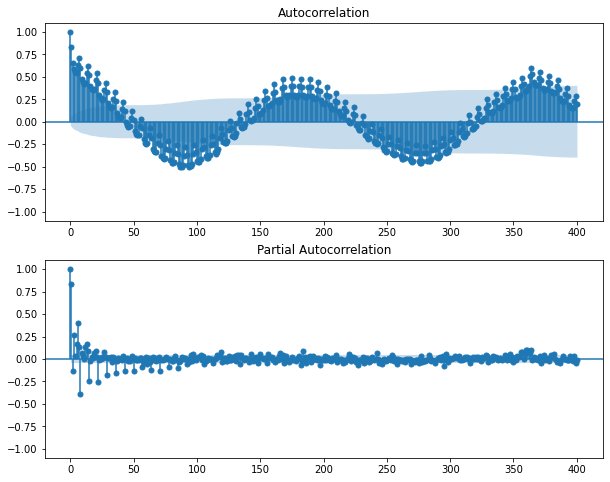

In [6]:
correlation_plot(df['power'], 400)

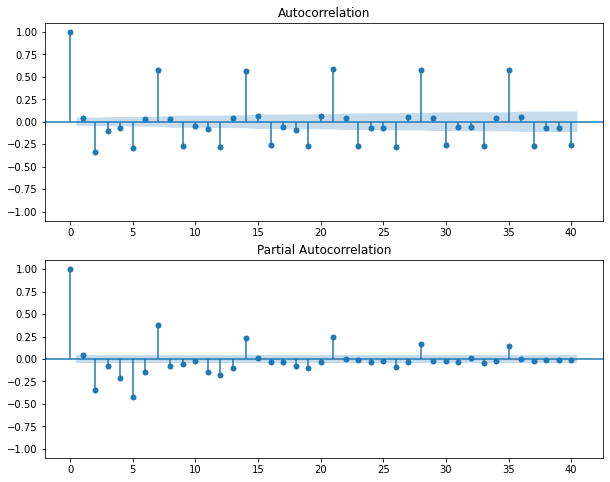

In [8]:
correlation_plot(df['power'].diff().dropna(), 40)

---ctt---
(-5.101249181831315, 0.0006847935007504168, 21, 1796, {'1%': -4.377593389378956, '5%': -3.835682144216698, '10%': -3.555299291096398}, 7019.981485297921)
---ct---
(-5.092673156493241, 0.00013902699838635926, 21, 1796, {'1%': -3.9638195379166485, '5%': -3.4129373525875115, '10%': -3.128490864337548}, 7018.064196890378)
---c---
(-5.101477058796369, 1.3923438095033887e-05, 21, 1796, {'1%': -3.433996253313391, '5%': -2.863150617970021, '10%': -2.5676274409973163}, 7016.082130375476)
---nc---
(-0.4632977701102768, 0.5111455089791658, 21, 1796, {'1%': -2.5669860019419546, '5%': -1.941150592387704, '10%': -1.6166729528243613}, 7040.123945355834)


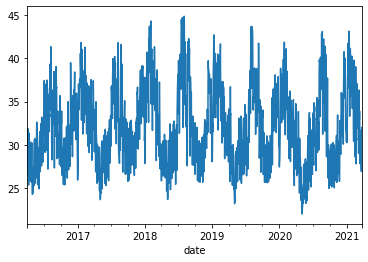

In [9]:
# 単位根過程であるかを検定。単位根過程（＝非定常過程）だとARを適用できない。
# p値が大きいと、単位根過程であることを棄却できない。すなわち、定常状態ではないと判断する。
y = df['power']
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

---ctt---
(-10.295880558974078, 9.21385399755269e-16, 25, 1791, {'1%': -4.377611464869554, '5%': -3.8356913459703605, '10%': -3.555304988915043}, 7034.042047922317)
---ct---
(-10.29803527467309, 5.494628673603811e-16, 25, 1791, {'1%': -3.963833659698418, '5%': -3.4129441928372706, '10%': -3.128494890279243}, 7032.063333441569)
---c---
(-10.296555823292852, 3.459046924226026e-18, 25, 1791, {'1%': -3.434006447337251, '5%': -2.863155118104396, '10%': -2.567629837184558}, 7030.157887324029)
---nc---
(-10.299269019337077, 2.2178100628649615e-18, 25, 1791, {'1%': -2.566989483598899, '5%': -1.9411510156922471, '10%': -1.6166725446383474}, 7028.163518130683)


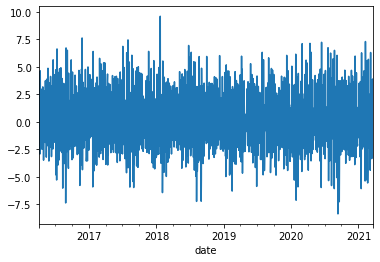

In [10]:
# トレンドはなさそうだが、定数項が無いことはなさそう。階差をとって定数項をなくす。
dy = df['power'].diff().dropna()
dy.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(dy, regression=r))

Text(0, 0.5, 'Residual')

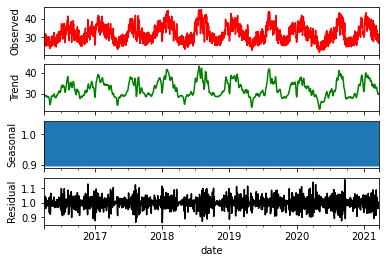

In [11]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomposition = sm.tsa.seasonal_decompose(y, model ='multiplicative')
decomposition.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

Text(0, 0.5, 'Residual')

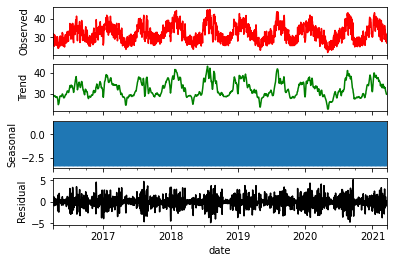

In [12]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomposition = sm.tsa.seasonal_decompose(y, model ='additive')
decomposition.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

In [13]:
# 考えられるパラメータの組み合わせを全て作成
# 季節階差は52週
max_p = 2 #AR(自己回帰過程)の次数：いくつ前までの数字を回帰させるか
max_d = 1 #I（和分過程）の次数：原系列に対して何回差分を取るか
max_q = 1 #MA（移動平均過程）の次数：いくつ前までのノイズを回帰させるか
max_sp = 1 #季節階差のARの次数
max_sd = 1 #季節階差のIの次数
max_sq = 1 #季節階差のMAの次数
params = []

seasonal = 52

for p in range(0, max_p + 1):
    for d in range(0, max_d + 1): 
        for q in range(0, max_q + 1): 
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1): 
                    for sq in range(0, max_sq + 1): 
                        params.append([p,d,q,sp,sd,sq])

len(params)

96

In [14]:
# MAPEを計算する自作関数を定義
def calc_mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

In [15]:
# テストするため, 学習用とテスト用データの分割

test_start = datetime.datetime(2020, 1, 1)
test_end = datetime.datetime(2021, 1, 1)

cond_test = y.index >= test_start
cond_test &= y.index < test_end
y_test = y[cond_test]

cond_train = y.index < test_start
y_train = y[cond_train]

# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(endog=y_train, trend="n", order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], seasonal), 
                                enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:  2.0min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.9min finished


,params,aic
91,"[2, 1, 1, 0, 1, 1]",5709.054160
95,"[2, 1, 1, 1, 1, 1]",5711.054113
87,"[2, 1, 0, 1, 1, 1]",5796.466134
92,"[2, 1, 1, 1, 0, 0]",5803.960092
89,"[2, 1, 1, 0, 0, 1]",5803.969131
93,"[2, 1, 1, 1, 0, 1]",5805.144214
75,"[2, 0, 1, 0, 1, 1]",5813.458805
83,"[2, 1, 0, 0, 1, 1]",5821.442643
43,"[1, 0, 1, 0, 1, 1]",5835.920866
79,"[2, 0, 1, 1, 1, 1]",5836.968436


In [16]:
# AICが最小のパラメータを当てはめる
best_params = aic_df.head(1)['params'].values[0]

model = sm.tsa.statespace.SARIMAX(endog=y_train, trend="n", order=(best_params[0], best_params[1], best_params[2]),
                                seasonal_order=(best_params[3], best_params[4], best_params[5], seasonal), 
                                enforce_invertibility = False, enforce_stationarity = False)
results = model.fit()

# テスト期間の予測値を出力する
y_pred = results.get_prediction(start = y_test.index[0], end = y_test.index[-1], dynamic=False)
 
# 点推定での予測値と区間推定での予測値を取り出す
pred_mean = y_pred.predicted_mean
pred_ci = y_pred.conf_int(alpha = .05)

# MAPEを算出
mape = calc_mape(y_test, pred_mean) 
print(mape)


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


12.705462171068065


In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              power   No. Observations:                 1370
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2849.527
Date:                            Fri, 26 Mar 2021   AIC                           5709.054
Time:                                    21:46:35   BIC                           5734.760
Sample:                                04-01-2016   HQIC                          5718.713
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6742      0.032     21.316      0.000       0.612       0.736
ar.L2         -0.3554      0.032    -11.092      0.000      -0.418      -0.293
ma.L1         -0.7773      0.028    -27.741      0.000      -0.832      -0.722
ma.S.L52      -1.0000    554.502     -0.002      0.999   -1087.803    1085.803
sigma2         4.7982   2660.678      0.002      0.999   -5210.035    5219.631
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.45   Prob(JB):                         0.30
Heteroskedasticity (H):               0.86   Skew:                             0.11
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

回帰係数のチェック
- ar.L1:一つ前の実績の半分にした値が影響している。
- ma.L1:一つ前の誤差のマイナスにしたものが影響している。
- ma.S.L52:一つ前の誤差のマイナスにしたものが影響している。が、信頼区間が広すぎる。
- sigma2 :信頼区間が広すぎる。

残差のチェック
- Jarque-Bera (JB):尖度と歪度による正規性の検定　H0は標本分布が正規分布に従う。
- Ljung-Box (L1) (Q)：H0　データは無作為（ラグと相関がないか）
- Heteroskedasticity (H):　H0　分散は均一である。

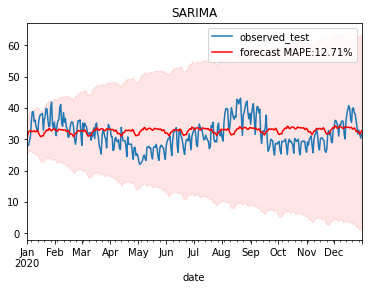

In [18]:
y_test.plot(label='observed_test')
pred_mean.plot(label=f'forecast MAPE:{mape:.2f}%', color = "r")
 
# 区間予測の折れ線グラフを描画
plt.title('SARIMA')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='r', alpha=.1)
plt.legend()
plt.show()

<AxesSubplot:xlabel='date'>

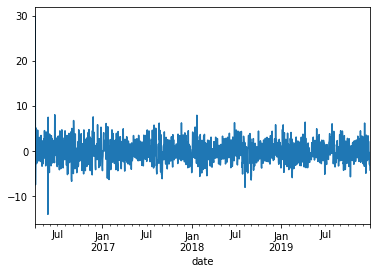

In [19]:
# GWの曜日のズレ？
results.resid.plot()

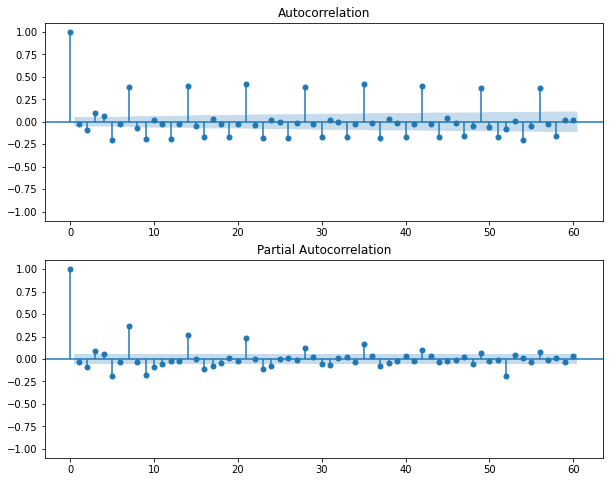

In [20]:
correlation_plot(results.resid)

## 外部変数として気温を追加

In [22]:
df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['date'] = pd.to_datetime(df_temperature['date'])
df_temperature = df_temperature.set_index('date')
df_temperature

,Unnamed: 0,temperature
date,,
2016-04-01,0,12.8
2016-04-02,1,10.5
2016-04-03,2,13.1
2016-04-04,3,15.6
2016-04-05,4,10.8
...,...,...
2021-02-25,1791,6.6
2021-02-26,1792,8.7
2021-02-27,1793,5.7


In [23]:
x = df_temperature['temperature']

In [24]:
cond_test = x.index >= test_start
cond_test &= x.index < test_end
x_test = x[cond_test]

cond_train = x.index < test_start
x_train = x[cond_train]

In [25]:
# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(
                                endog=y_train, exog=x_train, trend="n", order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], seasonal), 
        enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1545s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Batch computation too slow (19.3519s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:  3.6min remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.8min finished


,params,aic
91,"[2, 1, 1, 0, 1, 1]",5710.892580
95,"[2, 1, 1, 1, 1, 1]",5712.892526
87,"[2, 1, 0, 1, 1, 1]",5797.651936
92,"[2, 1, 1, 1, 0, 0]",5805.824661
89,"[2, 1, 1, 0, 0, 1]",5805.836149
93,"[2, 1, 1, 1, 0, 1]",5806.944267
75,"[2, 0, 1, 0, 1, 1]",5812.367703
83,"[2, 1, 0, 0, 1, 1]",5821.900065
43,"[1, 0, 1, 0, 1, 1]",5834.402419
47,"[1, 0, 1, 1, 1, 1]",5836.401579


In [26]:
# AICが最小のパラメータを当てはめる
best_params = aic_df.head(1)['params'].values[0]

model = sm.tsa.statespace.SARIMAX(
                                endog=y_train, exog=x_train, trend="n", order=(best_params[0], best_params[1], best_params[2]),
                                seasonal_order=(best_params[3], best_params[4], best_params[5], seasonal), 
    enforce_invertibility = False, enforce_stationarity = False)

results = model.fit()

# テスト期間の予測値を出力する
y_pred_temp = results.get_prediction(
                                start = y_test.index[0],
                                end = y_test.index[-1],
                                exog = x_test,
                                dynamic=False)
 
# 点推定での予測値と区間推定での予測値を取り出す
pred_mean_temp = y_pred_temp.predicted_mean
pred_ci_temp = y_pred_temp.conf_int(alpha = .05)

mape_temp = calc_mape(y_test, pred_mean_temp) 
print(mape_temp)

/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


12.534123459572374


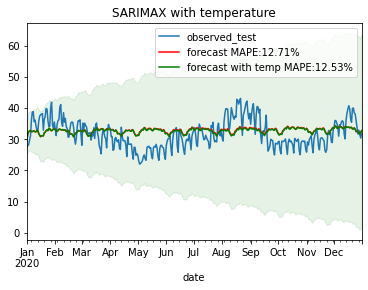

In [27]:
y_test.plot(label='observed_test')
pred_mean.plot(label=f'forecast MAPE:{mape:.2f}%', color = "r")
pred_mean_temp.plot(label=f'forecast with temp MAPE:{mape_temp:.2f}%', color = "g")

 
# 区間予測の折れ線グラフを描画
plt.title('SARIMAX with temperature')
plt.fill_between(pred_ci_temp.index, pred_ci_temp.iloc[:, 0], pred_ci_temp.iloc[:, 1], color='g', alpha=.1)
plt.legend()
plt.show()

<AxesSubplot:xlabel='date'>

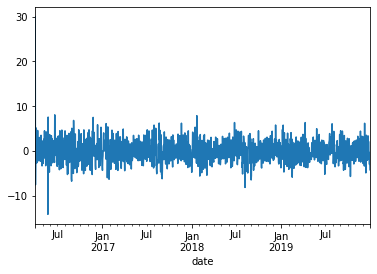

In [28]:
# GWの曜日のズレ？
results.resid.plot()

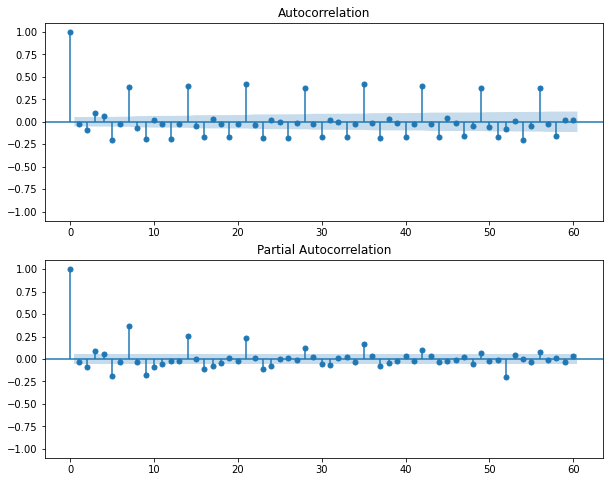

In [29]:
correlation_plot(results.resid)